In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline

from fastai.imports import *
from fastai.structured import *
from pandas_summary import DataFrameSummary
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from IPython.display import display
from sklearn import metrics

In [3]:
set_plot_sizes(12,14,16)

In [5]:
import feather

In [36]:
PATH = "data/bulldozers/"

df_raw = feather.read_dataframe('tmp/bulldozer-raw')
df_trn, y_trn, nas = proc_df(df_raw, 'SalePrice')

In [37]:
def split_vals(a,n): return a[:n], a[n:]
n_valid = 12000
n_trn = len(df_trn)-n_valid
X_train, X_valid = split_vals(df_trn, n_trn)
y_train, y_valid = split_vals(y_trn, n_trn)
raw_train, raw_valid = split_vals(df_raw, n_trn)

In [38]:
def rmse(x,y): return math.sqrt(((x-y)**2).mean())

def print_score(m):
    res = [rmse(m.predict(X_train), y_train), rmse(m.predict(X_valid), y_valid),
                m.score(X_train, y_train), m.score(X_valid, y_valid)]
    if hasattr(m, 'oob_score_'): res.append(m.oob_score_)
    print(res)

In [39]:
df_trn, y_trn, nas = proc_df(df_raw, 'SalePrice', subset=30000, 
                             na_dict=nas)
X_train, _ = split_vals(df_trn, 20000)
y_train, _ = split_vals(y_trn, 20000)

In [40]:
set_rf_samples(50000)

In [41]:
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, 
                        max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

/Users/lality/anaconda/lib/python3.6/site-packages/sklearn/ensemble/forest.py:732: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


[0.09656872590018623, 0.3432030210326877, 0.979912502966359, 0.7896462890102053, -5.993652440394614]


In [42]:
%time preds = np.stack([t.predict(X_valid) for t in m.estimators_])
np.mean(preds[:,0]), np.std(preds[:,0])

CPU times: user 1.77 s, sys: 57.6 ms, total: 1.82 s
Wall time: 1.83 s


(9.599691828532919, 0.4735475164008062)

In [43]:
def get_preds(t): return t.predict(X_valid)
%time preds = np.stack(parallel_trees(m, get_preds))
np.mean(preds[:,0]), np.std(preds[:,0])

CPU times: user 52.9 ms, sys: 61.4 ms, total: 114 ms
Wall time: 630 ms


(9.599691828532919, 0.4735475164008062)

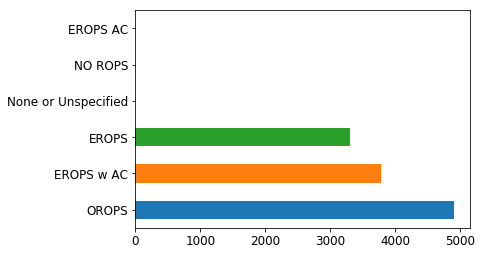

In [44]:
x = raw_valid.copy()
x['pred_std'] = np.std(preds, axis=0)
x['pred'] = np.mean(preds, axis=0)
x.Enclosure.value_counts().plot.barh();

In [45]:
flds = ['Enclosure', 'SalePrice', 'pred', 'pred_std']
enc_summ = x[flds].groupby('Enclosure', as_index=False).mean()
enc_summ

,Enclosure,SalePrice,pred,pred_std
0,EROPS,9.849178,9.842338,0.367649
1,EROPS AC,NaN,NaN,NaN
2,EROPS w AC,10.623971,10.436858,0.402354
3,NO ROPS,NaN,NaN,NaN
4,None or Unspecified,NaN,NaN,NaN
5,OROPS,9.682064,9.667316,0.312016


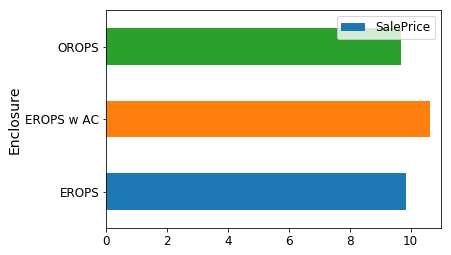

In [46]:
enc_summ = enc_summ[~pd.isnull(enc_summ.SalePrice)]
enc_summ.plot('Enclosure', 'SalePrice', 'barh', xlim=(0,11));

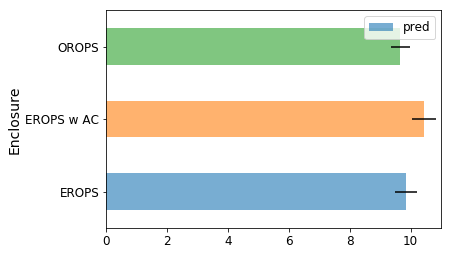

In [47]:
enc_summ.plot('Enclosure', 'pred', 'barh', xerr='pred_std', 
              alpha=0.6, xlim=(0,11));

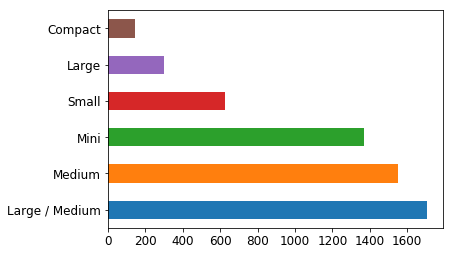

In [48]:
raw_valid.ProductSize.value_counts().plot.barh();

In [49]:
flds = ['ProductSize', 'SalePrice', 'pred', 'pred_std']
summ = x[flds].groupby(flds[0]).mean()
summ

,SalePrice,pred,pred_std
ProductSize,,,
Compact,9.735093,9.890789,0.445261
Large,10.470589,10.207354,0.535566
Large / Medium,10.691871,10.577089,0.405082
Medium,10.681511,10.447889,0.455614
Mini,9.535147,9.603881,0.341137
Small,10.324448,10.310657,0.381026


In [50]:
(summ.pred_std/summ.pred).sort_values(ascending=False)

ProductSize
Large             0.052469
Compact           0.045018
Medium            0.043608
Large / Medium    0.038298
Small             0.036955
Mini              0.035521
dtype: float64

In [27]:
# Feature Importance

In [51]:
fi = rf_feat_importance(m, df_trn); fi[:10]

,cols,imp
5,YearMade,0.188495
37,Coupler_System,0.105859
13,ProductSize,0.099545
14,fiProductClassDesc,0.073693
2,ModelID,0.059895
63,saleElapsed,0.049138
0,SalesID,0.042440
38,Grouser_Tracks,0.036224
10,fiSecondaryDesc,0.036211
8,fiModelDesc,0.033512


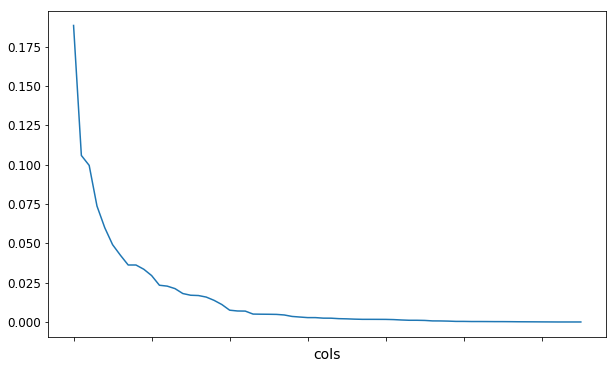

In [52]:
fi.plot('cols', 'imp', figsize=(10,6), legend=False);

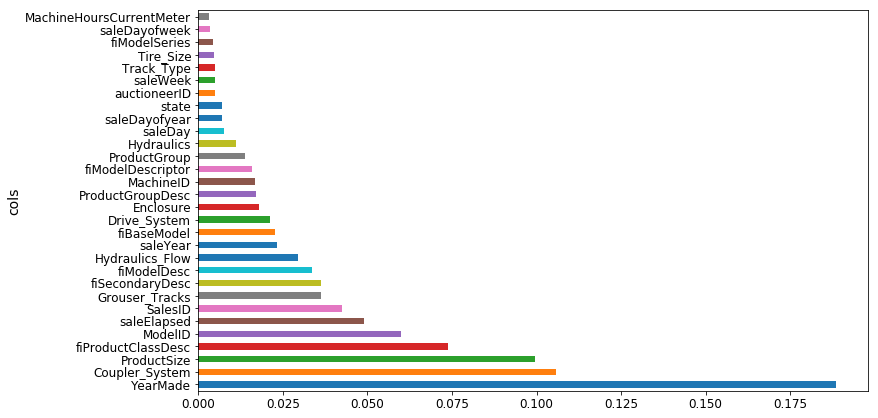

In [53]:
def plot_fi(fi): 
  return fi.plot('cols','imp','barh', figsize=(12,7), legend=False)
plot_fi(fi[:30]);

In [62]:
n_trn

389125

In [ ]:
to_keep = fi[fi.imp>0.005].cols; len(to_keep)
df_keep = df_trn[to_keep].copy()
X_train, X_valid = split_vals(df_keep, n_trn)
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, 
                       max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)